In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os
import scipy.stats as st
import json
import lib.galaxy_utilities as gu
import gzbuilder_analysis.parsing as pa

In [3]:
fitting_metadata = pd.read_pickle('lib/fitting_metadata.pkl')
models = pd.read_pickle('lib/models.pickle')

In [4]:
%run make_bulge_bar_dataframes.py

100%|██████████| 295/295 [01:00<00:00,  4.12it/s]


Could not find object for id 20902025
Could not find object for id 20901991
Could not find object for id 20902056
Could not find object for id 21686495
Could not find object for id 21686554
Could not find object for id 21686585
Could not find object for id 21686497


In [4]:
bulge_df = pd.read_pickle('lib/bulge_fractions.pkl').dropna()
bar_df = pd.read_pickle('lib/bar_fractions.pkl').dropna()
bar_length_df = pd.read_pickle('lib/bar_lengths.pkl')
display(bulge_df.head(3))
display(bar_df.head(3))
display(bar_length_df.dropna().head(3))

,GZB fraction,GZ2 bulge dominated,GZ2 no bulge
20902000,0.709677,False,0.068850
20902007,0.806452,False,0.062377
20902023,0.774194,False,0.000000


,GZB fraction,GZ2 bar fraction,Strongly barred,No bar
20902000,0.354839,0.736751,True,False
20902007,0.322581,0.072191,False,True
20902023,0.096774,0.022762,False,True


,GZB bar length,GZ2 bar fraction,GZB fraction
20902086,1.859249,0.450600,0.370787
20902008,2.821693,0.834784,0.516129
20902040,3.022961,0.747899,0.531250


## How frequently do people draw bulges relative to GZ2 pBulge?

In [5]:
gzb_bulge_mean = bulge_df['GZB fraction'].mean()
gzb_bulge_std = bulge_df['GZB fraction'].std()
print('\nGZB bulge fraction = {:.4f} ± {:.5f}\n'.format(
    gzb_bulge_mean, gzb_bulge_std
))
bulge_groups = bulge_df.groupby('GZ2 bulge dominated')
display(pd.DataFrame(
    np.hstack((bulge_groups.mean(), bulge_groups.std()))[:, :2],
    columns=('mean', 'std'),
#     index=bulge_groups.mean().index
))
bulge_dominated_mask = bulge_df['GZ2 bulge dominated'].astype(bool)

ttest_result = st.ttest_ind(
    bulge_df[bulge_dominated_mask]['GZB fraction'].values,
    bulge_df[~bulge_dominated_mask]['GZB fraction'].values
)
print('Probability samples are the same: {:%}'.format(ttest_result.pvalue))


GZB bulge fraction = 0.7510 ± 0.07969



,mean,std
0,0.751045,0.146487
1,0.750804,0.021049


Probability samples are the same: 98.461225%


Is there a negative correlation between the number of people flagging the galaxy as bulgeless, and the number of people using a bulge in their model?

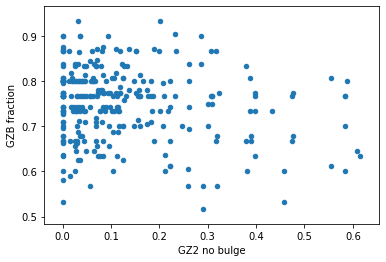

In [6]:
bulge_df.plot('GZ2 no bulge', 'GZB fraction', kind='scatter')

## How frequently do people draw bars relative to GZ2 pBar?

In [7]:
bar_df['type'] = pd.cut(bar_df['GZ2 bar fraction'], (-1, 0.2, 0.5, 2), labels=('No bar', 'Weak bar', 'Strong bar'))
bar_df.groupby('type')['GZB fraction'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
No bar,139.0,0.295327,0.105036,0.096774,0.229570,0.28125,0.356907,0.633333
Weak bar,92.0,0.383680,0.119570,0.129032,0.300000,0.38673,0.466667,0.677419
Strong bar,64.0,0.465755,0.143440,0.151515,0.366667,0.45914,0.566667,0.733333


In [8]:
print('GZB bar fraction = {:.4f} ± {:.5f}\n'.format(
    bar_df['GZB fraction'].mean(),
    bar_df['GZB fraction'].std()
))

print('P(model has bar | Strongly barred) = {:.4f} ± {:.4f}%'.format(
    bar_df.groupby('Strongly barred')['GZB fraction'].mean().loc[True],
    bar_df.groupby('Strongly barred')['GZB fraction'].std().loc[True],
))

print('P(model has bar | No bar)          = {:.4f} ± {:.4f}%'.format(
    bar_df.groupby('No bar')['GZB fraction'].mean().loc[True],
    bar_df.groupby('No bar')['GZB fraction'].std().loc[True],
))

ttest_result = st.ttest_ind(
    bar_df[bar_df['Strongly barred']]['GZB fraction'].values,
    bar_df[bar_df['No bar']]['GZB fraction'].values
)
print('\nProbability samples are the same: {:%}'.format(ttest_result.pvalue))

GZB bar fraction = 0.3599 ± 0.13638

P(model has bar | Strongly barred) = 0.4658 ± 0.1434%
P(model has bar | No bar)          = 0.2953 ± 0.1050%

Probability samples are the same: 0.000000%


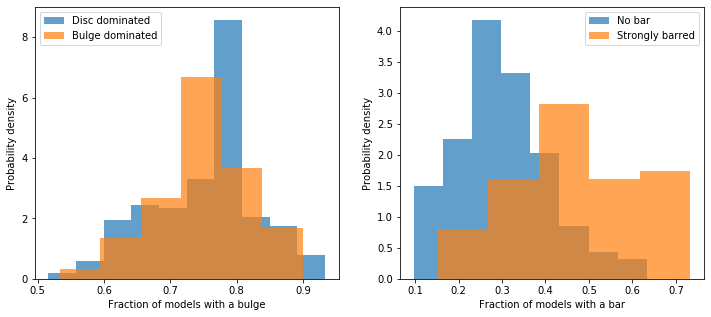

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
res = bulge_df.groupby('GZ2 bulge dominated')
plt.hist(bulge_df.loc[res.groups[False]]['GZB fraction'], bins='scott',
         alpha=0.7, label='Disc dominated', density=True)
plt.hist(bulge_df.loc[res.groups[True]]['GZB fraction'], bins='scott',
         alpha=0.7, label='Bulge dominated', density=True)
plt.title('')
plt.legend()
plt.xlabel('Fraction of models with a bulge')
plt.ylabel('Probability density');
plt.subplot(122)
plt.hist(bar_df[bar_df['No bar']]['GZB fraction'], bins='scott',
         alpha=0.7, label='No bar', density=True)
plt.hist(bar_df[bar_df['Strongly barred']]['GZB fraction'], bins='scott',
         alpha=0.7, label='Strongly barred', density=True)
plt.title('')
plt.legend()
plt.xlabel('Fraction of models with a bar')
plt.ylabel('Probability density');
plt.savefig('method-paper-plots/bulge-bar-population-comparison.pdf',
            bbox_inches='tight')

## How does pbar stack up against aggregate bar length?

Spearman correlation:


,GZB bar length,GZ2 bar fraction,GZB fraction
GZB bar length,1.000000,0.210194,0.161874
GZ2 bar fraction,0.210194,1.000000,0.560876
GZB fraction,0.161874,0.560876,1.000000


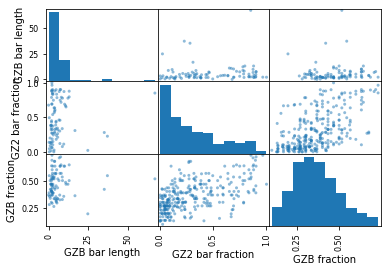

In [10]:
print('Spearman correlation:')
display(bar_length_df.corr('spearman'))
pd.plotting.scatter_matrix(bar_length_df);

In [11]:
cleaned = bar_length_df[bar_length_df['GZB bar length'] < 20]

,GZB bar length,GZ2 bar fraction,GZB fraction
GZB bar length,1.000000,0.250765,0.170689
GZ2 bar fraction,0.250765,1.000000,0.549005
GZB fraction,0.170689,0.549005,1.000000


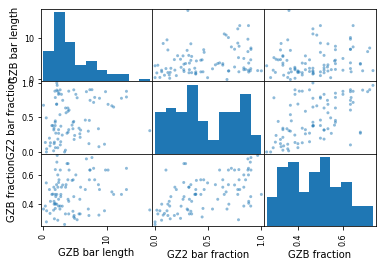

In [12]:
display(cleaned.corr('pearson'))
pd.plotting.scatter_matrix(cleaned);

In [13]:
def get_agg_bulge_reff(subject_id):
    diff_data = fitting_metadata.loc[subject_id]
    size_diff = fitting_metadata['size_diff']
    try:
      model = models['aggregate'].loc[subject_id]
    except KeyError:
      return np.nan
    bulge = model['bulge']
    disk = model['disk']
    if bulge is None or disk is None:
        return np.nan
    return bulge.get('Re', np.nan) / disk.get('Re', np.nan)

In [14]:
bulge_df['GZB bulge size'] = pd.Series(
  bulge_df.index, index=bulge_df.index
).apply(get_agg_bulge_reff)

Disc dominated (3.8086778180277463, 0.05165747831480911, 0.028847671975828503)
Bulge dominated (1.9396413627616371, 0.09528154450119924, 0.055206872902737056)


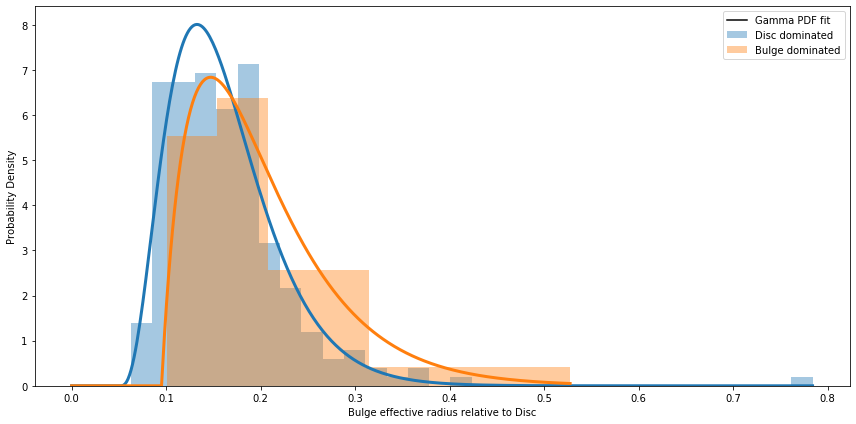

In [15]:
plt.figure(figsize=(12, 6))
for i, flag in enumerate((False, True)):
    mask = bulge_df['GZ2 bulge dominated'] == flag
    label = 'Bulge dominated' if flag else 'Disc dominated'
    data = bulge_df[mask]['GZB bulge size'].dropna()
    outlier_mask = np.abs(st.stats.zscore(data)) < 3
    counts, bins, patches = plt.hist(data, density=True, bins='auto', alpha=0.4, label=label, color='C{}'.format(i%10))
    params = st.gamma.fit(data[outlier_mask])
    x = np.linspace(0, np.max(bins), 500)
    rv = st.gamma(params[0], loc=params[1], scale=params[2])
    plt.plot(x, rv.pdf(x), c='C{}'.format(i%10), lw=3)
    print(label, params)
plt.plot([], [], 'k-', label='Gamma PDF fit')
plt.ylabel('Probability Density')
plt.xlabel('Bulge effective radius relative to Disc')
plt.legend()
plt.tight_layout()
plt.savefig('method-paper-plots/aggregate_bulge_size_comparison.pdf', bbox_inches='tight');